In [ ]:
import os
import sys
import itertools
import numpy as np
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from dnc.dnc import DNC
import dnc.utility as uf
from tqdm import tqdm
# from feedforward_controller import FeedforwardController
from basic_recurrent_controller import BasicRecurrentController
from focus_recurrent_controller import FocusRecurrentController
import time

cifs_path = "/media/data_cifs/DNC_Visual_Reasoning_Results_Logs"
#Remove logging  from previous training runs
os.system("rm {}/*.npy".format(cifs_path))

#Parameters of the task and the training
params = {}
params["timestamp"] = str(int(time.time()))
params["task"] = "lrb" 
params["num_iter"] = 15000
params["bsize"] = 10
params["input_side"] = 24
params["input_size"] = params["input_side"]**2
params["splits"] = 4
params["num_labels"] = 2
params["sequence_length"] = 20
params["half_max_item"] = 3
params["memory_words_num"] = 10
params["memory_word_size"] = 10
params["memory_read_heads"] = 1
params["print_step"] = 500
params["save_step"] = 4000

params["device"] = "/cpu:0" #Set this to /gpu:0 or /gpu:1 etc if you want to use the gpu instead
params["focus_type"] = "mask"

## Loss at every timestep
# params["loss_weightings"] = np.ones(params["sequence_length"]) 

## Loss at last timestep
params["loss_weightings"] = np.array([i == (params["sequence_length"] - 1) for i in range(params["sequence_length"])])  

## Loss increasing by timestep
# params["loss_weightings"] = np.arange(params["sequence_length"]) 

assert len(params["loss_weightings"]) == params["sequence_length"], ("Length of loss weights must be equal to sequence length")

#Test
_, _ = uf.make_ims(params)


#Make the directory for this run of the algorithm and save the params to it
os.system("mkdir {}/{}".format(cifs_path, params["timestamp"]))
np.save("{}/{}/params.npy".format(cifs_path, params["timestamp"]), params)


#Reset the graph and run the algorithm
tf.reset_default_graph()
with tf.device(params["device"]):
    sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))

    #build the neural computer
    ncomputer = DNC(
        FocusRecurrentController,
        input_size=params["input_size"],
        output_size=params["num_labels"],
        sequence_length=params["sequence_length"],
        controller_params={"focus_type":params["focus_type"]},
        memory_words_num=params["memory_words_num"],
        memory_word_size=params["memory_word_size"],
        memory_read_heads=params["memory_read_heads"],
        batch_size=params["bsize"]
    )
    assert ncomputer.controller.has_recurrent_nn

    output, loss = ncomputer.get_elementwise_loss(params["loss_weightings"]) 
    
    print "initializing..."
    updt = uf.get_updt(loss)
    init = tf.global_variables_initializer()
    sess.run(init)
    print "initialized!"

    loss_vals = []
    input_vals = []
    output_vals = []
    target_vals = []
    view_vals = []
    focuses = []
    focuses = []
    
    #Run the training
    for i in tqdm(range(params["num_iter"])):

        #Get the data and expected output for this batch
        Input, Target_Output = uf.make_ims(params)

        #Run the  update step
        OUT = sess.run([
            loss,
            output,
            ncomputer.packed_memory_view,
            updt] + 
            ncomputer.controller.focus_row +
            ncomputer.controller.focus_col +
            ncomputer.controller.focus_mask
            , feed_dict={
            ncomputer.input_data: Input,
            ncomputer.target_output: Target_Output
        })
        l, o, v = OUT[:3]
        #For simplicity and easy of switching, we build all of these now. Delete this when we decide on mask versus row_col
        fr = OUT[4:4 + len(ncomputer.controller.focus_row)]
        fc = OUT[4 + len(ncomputer.controller.focus_row):4 + len(ncomputer.controller.focus_row) +
                 len(ncomputer.controller.focus_col)]
        fm = OUT[4 + len(ncomputer.controller.focus_row) + len(ncomputer.controller.focus_col):] 

        #Keep track of the values at this timestep
        loss_vals.append(l)
        input_vals.append(Input)
        output_vals += list(o)
        view_vals.append(v)
        target_vals += list(Target_Output)
        if params["focus_type"] == "rowcol":
            focuses.append((np.array(fr)[:,0,:], np.array(fc)[:,0,:]))
        elif params["focus_type"] == "mask":
            focuses.append(np.array(fm)[:,0,:])

        #Print the loss and accuracy thus far
        if len(target_vals) % params["print_step"] == 0 and len(target_vals) > 0:
            print "np.array(target_vals).shape", np.array(target_vals).shape
            print "np.array(output_vals).shape", np.array(output_vals).shape

            losses = {}
            losses["loss"] = np.mean(loss_vals[-params["print_step"]:])
            losses["matches"] = np.mean(np.argmax(np.array(output_vals)[-params["print_step"]:, -1], -1) == 
                                     np.argmax(np.array(target_vals)[-params["print_step"]:, -1], -1))

            print "loss", losses["loss"]
            print "matches", losses["matches"]

            np.save("{}/{}/losses_{}.npy".format(cifs_path, params["timestamp"], i), losses)

        #Save the model and the masks generated
        if len(target_vals) % params["save_step"] == 0 and len(target_vals) > 0:
            print "saving for {}".format(i)
            np.save("{}/{}/outputs_{}.npy".format(cifs_path, params["timestamp"], i), output_vals[-50:])
            np.save("{}/{}/targets_{}.npy".format(cifs_path, params["timestamp"], i), target_vals[-50:])
            np.save("{}/{}/inputs_{}.npy".format(cifs_path, params["timestamp"], i), input_vals[-50:])
            np.save("{}/{}/focuses_{}.npy".format(cifs_path, params["timestamp"], i), focuses[-50:])
            #Save the weights of the model - disabled because the model checkpoints are big and bulky 
            # ncomputer.save(sess, 
            #                "{}/{}".format(params["timestamp"]), cifs_path, 
            #                "saved_weights_{}.npy".format(i))






/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)
100%|██████████| 20/20 [01:13<00:00,  3.84s/it]


initializing...
computing gradients...


  0%|          | 0/20 [00:00<?, ?it/s]100%|██████████| 20/20 [00:00<00:00, 241.22it/s]


applying gradients...


In [19]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import os
import sys
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from dnc.dnc import DNC
import dnc.utility as uf
import matplotlib.pyplot as plt
# from feedforward_controller import FeedforwardController
from basic_recurrent_controller import BasicRecurrentController
from focus_recurrent_controller import FocusRecurrentController

from tqdm import tqdm
import time
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 20)

sess = None


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


outputs: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
truth: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


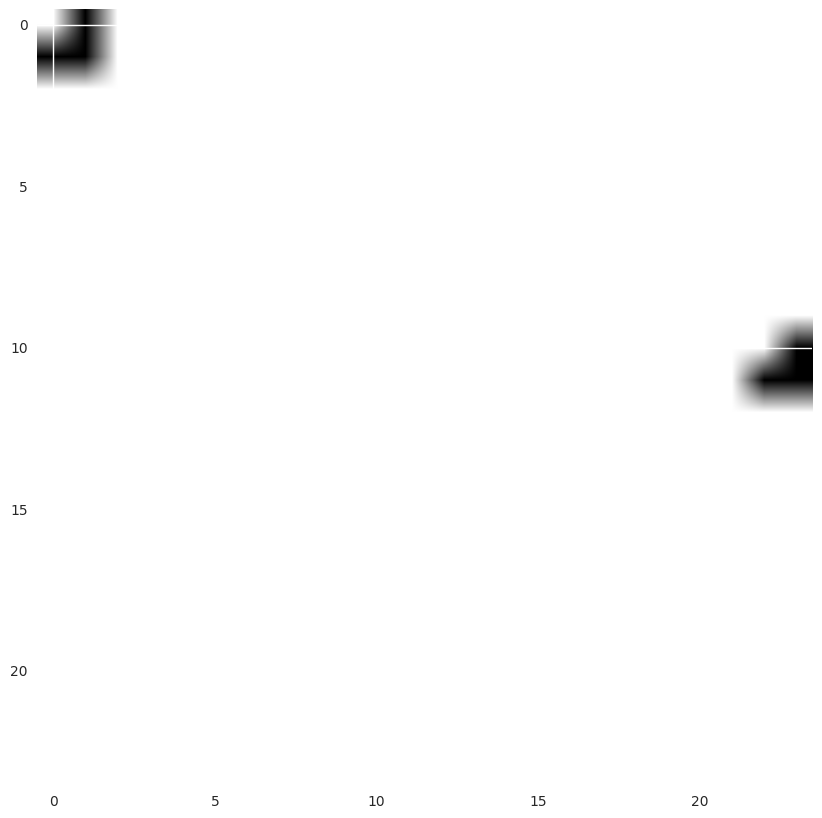

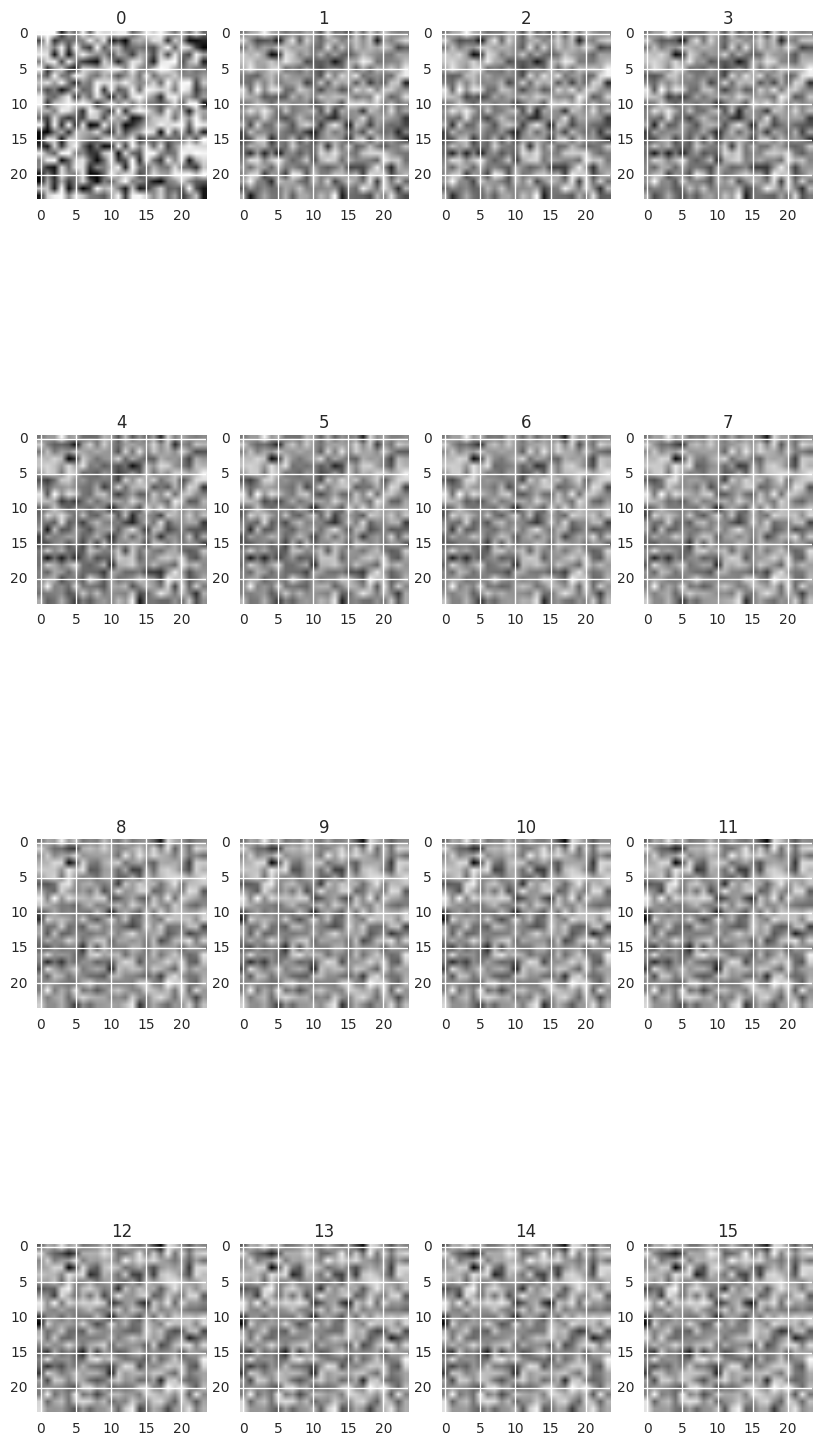

In [26]:
# Visualize the image and the masks for a timestep

cifs_path = "/media/data_cifs/DNC_Visual_Reasoning_Results_Logs"
timestep = "1485048753"
num = "799"
outputs = np.load("{}/{}/outputs_{}.npy".format(cifs_path, timestep, num))
targets = np.load("{}/{}/targets_{}.npy".format(cifs_path, timestep, num))
inputs = np.load("{}/{}/inputs_{}.npy".format(cifs_path, timestep, num))
focuses = np.load("{}/{}/focuses_{}.npy".format(cifs_path, timestep, num))

ind = 1
print "outputs:", np.argmax(outputs[ind], -1)
print "truth:", np.argmax(targets[ind], -1)


plt.figure()
plt.imshow(np.reshape(inputs[ind][0][0], (24,24)))
plt.figure()
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.title(i)
    plt.imshow(np.reshape(focuses[ind][i], (24,24)))
    

In [4]:
# b = 0
# for r in np.reshape(I[b][0], (24,24)):
#     print str(r).replace("\n","").replace(". ", "")


((10, 16, 576), (10, 16, 2), array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1]))

In [5]:
# for r in np.reshape(I[b][i], (24,24)):
#     print str(r).replace("  ", "").replace("\n", "")

In [11]:
np.sqrt(576)

24.0

In [3]:
# num_labels = 2
def make_ims(kind, size=8, splits=4):
    if kind == "center":
        Input, _, Target_Output = uf.get_center_bar_images(bsize, size=size, splits=splits, stagger=False)
    elif kind == "right":
        Input, _, Target_Output = uf.get_right_bar_images(bsize, size=size, splits=splits, stagger=False)
    return Input, Target_Output


if not sess is None:
    sess.close()

bsize = 1
input_size = 64
num_labels = 2
sequence_length = 16
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))

ncomputer = DNC(
    FocusRecurrentController,
    input_size=input_size,
    output_size=num_labels,
    max_sequence_length=sequence_length,
    memory_words_num=10,
    memory_word_size=10,
    memory_read_heads=1,
    batch_size=bsize
)
assert ncomputer.controller.has_recurrent_nn

raw_outputs, memory_views = ncomputer.get_outputs()
output = tf.argmax(raw_outputs[:, sequence_length - 1, :], 1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(raw_outputs[:, sequence_length - 1, :], 
                                                              ncomputer.target_output_final))

start = time.time()
updt = uf.get_updt(loss)
print time.time() - start

init = tf.global_variables_initializer()
print "initializing..."
sess.run(init)
print "initialized!"


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)
100%|██████████| 16/16 [00:16<00:00,  1.01it/s]


computing gradients...


  0%|          | 0/19 [00:00<?, ?it/s]100%|██████████| 19/19 [00:00<00:00, 264.24it/s]


applying gradients...
45.584788084
initializing...
initialized!


In [4]:

print_step = 200
losses = []
inputs = []
outputs = []
targets = []
views = []
raw_focuses_row = []
raw_focuses_col = []
focuses = []

for i in tqdm(range(1000000)):
    
    Input, Target_Output = make_ims("right")

    OUT = sess.run([
        loss,
        output,
        memory_views,
        updt] + 
        ncomputer.controller.focus_row +
        ncomputer.controller.focus_col
        , feed_dict={
        ncomputer.input_data: Input,
        ncomputer.target_output_final: Target_Output,
        ncomputer.sequence_length: sequence_length
    })
    l, o, v = OUT[:3]
    fr = OUT[4:4+len(ncomputer.controller.focus_row)]
    fc = OUT[4+len(ncomputer.controller.focus_row):]
    pairs = zip(np.argmax(np.array(fr)[:,0,:], -1), np.argmax(np.array(fr)[:,0,:], -1))

    losses.append(l)
    inputs.append(Input)
    outputs += list(o)
    views.append(v)
    targets += list(np.argmax(Target_Output, axis=-1))
    raw_focuses_row.append(np.array(fc)[:,0,:])
    raw_focuses_col.append(np.array(fc)[:,0,:])
    focuses.append(pairs)
    if len(targets) % print_step == 0 and len(targets) > 0:
        print "loss", np.mean(losses[-print_step:])
        print "matches", np.mean(np.array(targets[-print_step:]) == np.array(outputs[-print_step:]))


  0%|          | 0/1000000 [00:00<?, ?it/s]dnc/utility.py:147: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  label[pos] = 1
  0%|          | 200/1000000 [00:58<71:02:26,  3.91it/s] 

loss 0.693091
matches 0.52


  0%|          | 219/1000000 [01:03<56:35:25,  4.91it/s]   0%|          | 202/1000000 [00:59<99:31:39,  2.79it/s] 

KeyboardInterrupt: 

In [6]:
focuses[-1]

[(2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3)]

In [25]:
# rup

array([[-0.00196703,  0.00065425, -0.00131982, -0.00144165]], dtype=float32)

In [ ]:
# plt.subplot(2,2,1)
# plt.imshow(np.reshape(Input[0][0], (4,4)))
# plt.subplot(2,2,2)
# plt.imshow(np.reshape(Input[0][1], (4,4)))
# plt.subplot(2,2,3)
# plt.imshow(np.reshape(Input[0][2], (4,4)))
# plt.subplot(2,2,4)
# plt.imshow(np.reshape(Input[0][3], (4,4)))

In [ ]:
# focus_row_updater, focus_col_updater, normed_nn_output, rup = sess.run([
#         ncomputer.controller.focus_row_updater,
#         ncomputer.controller.focus_col_updater,
#         ncomputer.controller.nn_output/(1e-4 + tf.reduce_sum(tf.abs(ncomputer.controller.nn_output))), 
#         tf.matmul(ncomputer.controller.nn_output/(1e-4 + tf.reduce_sum(tf.abs(ncomputer.controller.nn_output))), 
#                   ncomputer.controller.focus_row_updater)
        
#     ], feed_dict={
#         ncomputer.input_data: Input,
#         ncomputer.target_output_final: Target_Output,
#         ncomputer.sequence_length: sequence_length
#     })

In [ ]:
# ix = 4
# v = views[ix]
# print targets[ix]
# Input = inputs[ix]

# for i, w, r in zip(range(4), np.squeeze(v['write_weightings'][0]), np.squeeze(v['read_weightings'][0])):
#     plt.subplot(2,2,i + 1)
#     plt.plot(w, label="w")
#     plt.plot(r, label="r")
#     plt.legend()

In [20]:
# # batch_x, batch_y = mnist.train.next_batch(bsize)
# # Input, Target_Output = get_im_sequence(batch_x, batch_y)
# Input, _, Target_Output = make_ims(bsize, size=im_size, splits=im_splits)

# l, o, v, _ = sess.run([
#     loss,
#     output,
#     memory_views, 
#     updt
# ], feed_dict={
#     ncomputer.input_data: Input,
#     ncomputer.target_output_final: Target_Output,
#     ncomputer.sequence_length: sequence_length
# })
# o

array([1])

In [32]:

# with tf.variable_scope("testing4"): 
#     Xf2 = tf.placeholder(tf.float32, [1, 26], name="Xf2")
#     state2 = tf.placeholder(tf.float32, [1, 256], name="state2")
#     out = ncomputer.controller.run_controller_network(Xf2, state2)
#     init = tf.global_variables_initializer()
#     print "initializing..."
#     sess.run(init)
#     print "initialized!"
#     l1_output, l2_output, l3_output, nn_output = sess.run([
#             ncomputer.controller.l1_output,
#             ncomputer.controller.l2_output,
#             ncomputer.controller.l3_output, 
#             ncomputer.controller.nn_output
#         ], feed_dict={
#             Xf2: np.zeros((1, 26)),
#             state2: np.random.random((1, 256))
#         })

initializing...
initialized!


In [6]:
# ncomputer.save(sess, "ckpts", "basic_recurrent_controller_get_lrb_images_task.ckpt")

In [ ]:

#TODO: VISUALIZE GRADIENTS AND MEMORY

















In [34]:
# print Target_Output
# plt.subplot(2,2,1)
# plt.imshow(np.reshape(Input[0][0], (4,4)))
# plt.subplot(2,2,2)
# plt.imshow(np.reshape(Input[0][1], (4,4)))
# plt.subplot(2,2,3)
# plt.imshow(np.reshape(Input[0][2], (4,4)))
# plt.subplot(2,2,4)
# plt.imshow(np.reshape(Input[0][3], (4,4)))